In [1]:
import os

os.environ["http_proxy"] = "http://localhost:7890"
os.environ["https_proxy"] = "http://localhost:7890"

3.2获取金融市场数据

3.2.1下载数据到指定目录

使用Qlib内置的数据源并下载到本地目录，用于后续研究使用：

In [2]:
import qlib
# from qlib.contrib.model.pytorch_alstm_ts import ALSTM
from qlib.tests.data import GetData
from qlib.constant import REG_CN

data_uri = 'H:/data/qlib/qlib_data/cn_data'
GetData().qlib_data(target_dir=data_uri, region=REG_CN)
qlib.init(provider_uri=data_uri, region=REG_CN)

2024-01-27 12:24:16.588 | WARNING  | qlib.tests.data:download_data:79 - The data for the example is collected from Yahoo Finance. Please be aware that the quality of the data might not be perfect. (You can refer to the original data source: https://finance.yahoo.com/lookup.)
2024-01-27 12:24:16.591 | INFO     | qlib.tests.data:download_data:82 - qlib_data_cn_1d_latest.zip downloading......
196549632it [00:42, 4660576.63it/s]                               
2024-01-27 12:24:58.784 | WARNING  | qlib.tests.data:_unzip:104 - will delete the old qlib data directory(features, instruments, calendars, features_cache, dataset_cache): H:\data\qlib\qlib_data\cn_data
2024-01-27 12:24:58.785 | INFO     | qlib.tests.data:_unzip:108 - H:\data\qlib\qlib_data\cn_data\20240127122415_qlib_data_cn_1d_latest.zip unzipping......
100%|██████████| 31008/31008 [00:39<00:00, 787.51it/s] 
[27924:MainThread](2024-01-27 12:25:38,431) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[27924:MainTh

3.2.3数据核心模块类

Qlib中关于数据主要有以下三个模块：

Data Loader: 从数据源加载数据，数据源可以是已经转换为qlib内置格式的数据，也可以是其他外部数据；

Data Handler: 对数据进行预处理，比如常见的缺失值、标准化等；

Dataset: 为模型的训练准备数据，类似Pytorch中的Dataset。

1)QlibDataLoader

In [3]:
from qlib.data.dataset.loader import QlibDataLoader

# 加载原始特征，比如收盘价、最高价
qdl = QlibDataLoader(config=(['$close', '$high'], ['close', 'high']))
qdl.load(instruments=['SH600519'], start_time='20190101', end_time='20191231')
# 可以通过freq参数设置周期，默认freq='day'

,,close,high
datetime,instrument,,
2019-01-02,SH600519,124.290070,126.991760
2019-01-03,SH600519,122.426697,124.846176
2019-01-04,SH600519,124.916748,126.093285
2019-01-07,SH600519,125.640930,126.639015
2019-01-08,SH600519,125.495667,126.991760
...,...,...,...
2019-12-25,SH600519,238.729614,240.687988
2019-12-26,SH600519,239.024445,240.473206
2019-12-27,SH600519,244.899506,246.794693


除了直接加载原始特征，有时我们需要对不同的原始特征做一些运算生成新的特征，比如我们想计算收盘价的均线。这时我们可以使用qlib的算式表达式功能，直接在加载时进行计算，具体请看下面案例。



In [4]:
# 这次我们加载沪深300成分股的10日和30日收盘价指数加权均价
# market = 'csi500' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
market = ['SH600519']
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']  # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']
qdl_ma = QlibDataLoader(config=(close_ma, ma_names))
qdl_ma.load(instruments=market, start_time='20190101', end_time='20190110')

,,EMA10,EMA30
datetime,instrument,,
2019-01-02,SH600519,119.930656,120.109848
2019-01-03,SH600519,120.440567,120.280975
2019-01-04,SH600519,121.334900,120.620201
2019-01-07,SH600519,122.180038,120.984444
2019-01-08,SH600519,122.821526,121.309120
2019-01-09,SH600519,123.782562,121.776146
2019-01-10,SH600519,124.656723,122.245842


In [5]:
# 这次我们加载沪深300成分股的10日和30日收盘价指数加权均价
market = 'csi500'  # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
# market = ['SH600519']
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']  # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']
qdl_ma = QlibDataLoader(config=(close_ma, ma_names))
qdl_ma.load(instruments=market, start_time='20190101', end_time='20190110')

EMA10      EMA30
datetime   instrument                      
2019-01-02 SH600006     2.485089   2.554589
           SH600008     3.342541   3.420600
           SH600017     1.466812   1.497474
           SH600021     1.959099   1.924196
           SH600022     2.603461   2.664191
...                          ...        ...
2019-01-10 SZ300383     5.047935   4.949678
           SZ300413     2.911690   2.915875
           SZ300418     1.794226   1.820802
           SZ300450    11.260673  11.399063
           SZ300459     5.113735   5.141619

[3479 rows x 2 columns]

qlib把类似“EMA”称为算子（operator），qlib中全部支持的算子可以在以下源码中找到：/qlib/data/ops.py中，主要有：

ChangeInstrument, Rolling, Ref, Max, Min, Sum, Mean, Std, Var, Skew, Kurt, Med, Mad, Slope, Rsquare, Resi, Rank, Quantile, Count, EMA, WMA, Corr, Cov, Delta, Abs, Sign, Log, Power, Add, Sub, Mul, Div, Greater, Less, And, Or, Not, Gt, Ge, Lt, Le, Eq, Ne, Mask, IdxMax, IdxMin, If, Feature, PFeature，

有时我们需要对计算的数据进行分组，最常用的是分为特征组“feature”和“label”组，此时我们可以传入dict格式的参数至config中，具体看下面实例：



In [6]:
# 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
# market = 'sh000300' 
market = 'csi500'
# EMA($close, 10)表示计算close的10日指数加权均线
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']
ma_names = ['EMA10', 'EMA30']
ret = ["Ref($close, -1)/$close-1"]
# 下一日收益率, Ref($close, -1)表示下一日收盘价
ret_name = ['next_ret']
qdl_ma_gp = QlibDataLoader(config={'feature': (close_ma, ma_names), 'label': (ret, ret_name)})
qdl_ma_gp.load(instruments=market, start_time='20190101', end_time='20190110')

feature                label
                           EMA10      EMA30  next_ret
datetime   instrument                                
2019-01-02 SH600006     2.485089   2.554589  0.011142
           SH600008     3.342541   3.420600 -0.017493
           SH600017     1.466812   1.497474  0.011111
           SH600021     1.959099   1.924196 -0.012330
           SH600022     2.603461   2.664191  0.000000
...                          ...        ...       ...
2019-01-10 SZ300383     5.047935   4.949678  0.002888
           SZ300413     2.911690   2.915875 -0.005245
           SZ300418     1.794226   1.820802  0.011364
           SZ300450    11.260673  11.399063 -0.012022
           SZ300459     5.113735   5.141619  0.005533

[3479 rows x 3 columns]

2）Data Handler

通过Data Loader加载特征后，模型训练前需要对特征数据进行一些预处理，比如缺失值、标准化等处理。这是Data Handler主要任务。我们先看一个案例：



array([[<Axes: title={'center': 'Return'}>]], dtype=object)

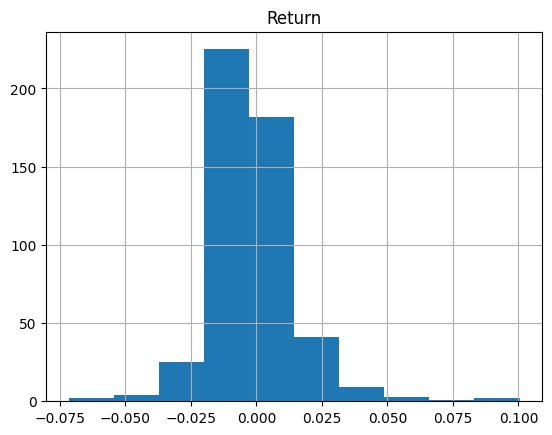

In [7]:
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import CSZScoreNorm, DropnaProcessor

qdl = QlibDataLoader(config=(['$close/Ref($close, 1)-1'], ['Return']))
# df = qdl.load(instruments='sh000300', start_time='20210101', end_time='20210430') 
df = qdl.load(instruments='csi500', start_time='20190101', end_time='20190110')
# 是否有空值
df.isna().sum()
# 原始数据分布
df.xs('2019-01-10').hist()

[27924:MainThread](2024-01-27 12:28:10,672) INFO - qlib.timer - [log.py:127] - Time cost: 14.414s | Loading data Done
[27924:MainThread](2024-01-27 12:28:10,674) INFO - qlib.timer - [log.py:127] - Time cost: 0.002s | DropnaProcessor Done
G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\data\dataset\processor.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].groupby("datetime", group_keys=False).apply(self.zscore_func)
[27924:MainThread](2024-01-27 12:28:10,687) INFO - qlib.timer - [log.py:127] - Time cost: 0.012s | CSZScoreNorm Done
[27924:MainThread](2024-01-27 12:28:10,688) INFO - qlib.timer - [log.py:127] - Time cost: 0.016s | fit & process data Done
[27924:MainThread](2024-01-27 12:28:10,689) INFO - qlib.t

array([[<Axes: title={'center': 'Return'}>]], dtype=object)

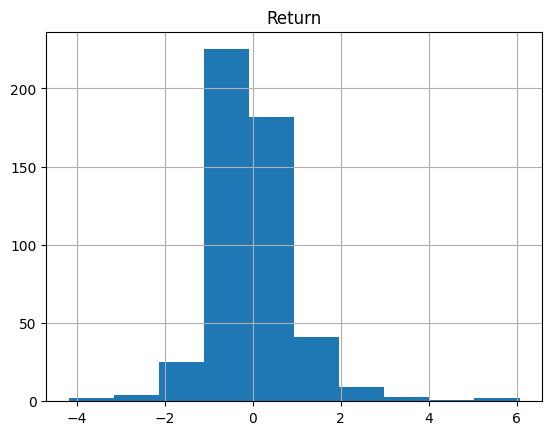

In [8]:
# 实例化DataHandler
dh = DataHandlerLP(
    # instruments='sh000300', start_time='20210101', end_time='20210120',
    instruments='csi500', start_time='20190101', end_time='20190110',
    learn_processors=[DropnaProcessor(), CSZScoreNorm()],
    data_loader=qdl)
df_hdl = dh.fetch(data_key=DataHandlerLP.DK_L)  # 获取处理后的数据，处理过程为先去空值，再截面标准化。
# 查看是否还存在空值
df_hdl.isna().sum()
# CSZScoreNorm截面标准化处理后的数据分布
df_hdl.xs('2019-01-10').hist()

从以上的例子可以看出，实例化Data Handler需要以下几个参数：

基本信息，如instruments，start_time，end_time

infer_processors，数据处理器，列表格式。由Dataloader加载的数据会依次经过该列表中的processor进行处理。（后面会详细介绍）

data_loader，数据加载器实例。

Data Handler实例化之后，通过fetch方法获取处理后的数据，这里的参数DataHandlerLP.DK_L会在Learn Processor VS Infer Processor详细介绍。

3）Dataset

Dataset主要是为模型训练注入数据，其中主要的参数有：

handler：实例化的Data Handler

segment：训练、验证、测试数据集的划分

一个完整的代码示例如下：

In [9]:
from qlib.data.dataset.processor import ZScoreNorm
from qlib.data.dataset import DatasetH

# 沪深300股票池代码，在instruments文件夹下必须有对应的文件
# Data Loader
# market = 'sh000300' #sh000300.txt
market = 'csi500'

# EMA($close, 10)表示计算close的10日指数加权均线
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']
# 下一日收益率, Ref($close, -1)表示下一日收盘价
ma_names = ['EMA10', 'EMA30']
ret = ["Ref($close, -1)/$close-1"]
ret_name = ['next_ret']
qdl_ma_gp = QlibDataLoader(config={'feature': (close_ma, ma_names), 'label': (ret, ret_name)})
# 实例化Data Handler
shared_processors = [DropnaProcessor()]
learn_processors = [CSZScoreNorm()]  # processor that applies cross sectional z-score normalization
infer_processors = [
    ZScoreNorm(fit_start_time='20190101', fit_end_time='20211231')]  # processor that applies z-score normalization
dh_pr_test = DataHandlerLP(
    # instruments='sh000300', 
    instruments='csi500',
    start_time='20190101',
    end_time='20211231',
    process_type=DataHandlerLP.PTYPE_I,
    learn_processors=learn_processors,
    shared_processors=shared_processors,
    infer_processors=infer_processors,
    data_loader=qdl_ma_gp)
ds = DatasetH(dh_pr_test, segments={"train": ('20190101', '20201231'), "test": ('20210101', '20211231')})
# 准备训练数据
ds.prepare('train')
# 准备测试数据
ds.prepare('test')

[27924:MainThread](2024-01-27 12:28:40,016) INFO - qlib.timer - [log.py:127] - Time cost: 29.150s | Loading data Done
[27924:MainThread](2024-01-27 12:28:40,027) INFO - qlib.timer - [log.py:127] - Time cost: 0.010s | DropnaProcessor Done
[27924:MainThread](2024-01-27 12:28:40,140) INFO - qlib.timer - [log.py:127] - Time cost: 0.112s | ZScoreNorm Done
[27924:MainThread](2024-01-27 12:28:40,725) INFO - qlib.timer - [log.py:127] - Time cost: 0.582s | CSZScoreNorm Done
[27924:MainThread](2024-01-27 12:28:40,726) INFO - qlib.timer - [log.py:127] - Time cost: 0.709s | fit & process data Done
[27924:MainThread](2024-01-27 12:28:40,727) INFO - qlib.timer - [log.py:127] - Time cost: 29.861s | Init data Done


,,EMA10,EMA30,next_ret
datetime,instrument,,,
